# Goal: Minimal 1D conditional DDPM
- 目標函數: $f(x)=\frac{1}{1+x^2}$
- 讓網路學會：在任意 $t$，從 $y_t$ (加噪後) 與 $x$ 預測噪聲 $\epsilon$
- 然後從純噪聲經由反向過程還原出 $y_0 ≈ f(x)$

In [1]:
import math, torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt

#### Config


In [2]:
DEVICE        = 'cpu' #cuda' if torch.cuda.is_available() else 'cpu'
T             = 500        # diffusion steps
BATCH_SIZE    = 256
TRAIN_ITERS   = 2000       # 訓練步數（小玩具 2k 就看得到效果，再加更好）
LR            = 2e-3
HIDDEN        = 128
TIME_DIM      = 64
N_TRAIN_SAMP  = 4096       # 訓練資料量（隨機抽 x~U[-1,1]）
DETERMINISTIC = True       # True = 取樣時不再加隨機噪聲（更平滑）


In [3]:
# Target f(x)
def f(x):
    return 1.0/(1.0+25.0*x**2)

In [4]:
# ---------------------------
# Schedules
# ---------------------------
betas  = torch.linspace(1e-4, 0.02, T, device=DEVICE)
alphas = 1.0 - betas
abar   = torch.cumprod(alphas, dim=0)
sqrt_abar  = torch.sqrt(abar)
sqrt_1mabar= torch.sqrt(1.0 - abar)
sqrt_rcp_a = torch.sqrt(1.0 / alphas)

In [5]:
# ---------------------------
# Time embedding  ### 這塊不太懂
# ---------------------------
def t_embed(t, dim=TIME_DIM):
    # t: (B,) -> (B, dim)
    half = dim // 2
    freqs = torch.exp(torch.linspace(math.log(1.0), math.log(10000.0), half, device=t.device))
    args = t.float().unsqueeze(1) / 1000.0
    emb = torch.cat([torch.sin(args*freqs), torch.cos(args*freqs)], dim=-1)
    if dim % 2 == 1:
        emb = F.pad(emb, (0,1))
    return emb

In [6]:
# ---------------------------
# Epsilon network: eps_hat = eps_theta(y_t, x, t)
# ---------------------------
class EpsMLP(nn.Module):
    def __init__(self, hidden=HIDDEN, time_dim=TIME_DIM):
        super().__init__()
        self.t_proj = nn.Sequential(nn.Linear(time_dim, hidden), nn.SiLU())
        self.net = nn.Sequential(
            nn.Linear(hidden + 2, hidden),  # concat [y_t, x] + t_proj
            nn.ReLU(),#SiLU(), ### 但原本的DDPM 就是要用SiLU(結果蠻差的)
            nn.Linear(hidden, hidden),
            nn.ReLU(),#SiLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, y_t, x, t):
        h_t = self.t_proj(t_embed(t))
        h   = torch.cat([y_t, x, h_t], dim=1)
        return self.net(h)

model = EpsMLP().to(DEVICE)
opt   = torch.optim.AdamW(model.parameters(), lr=LR)

In [7]:
# ---------------------------
# q_sample: y_t = sqrt(abar_t) y0 + sqrt(1-abar_t) * eps
# ---------------------------
def q_sample(y0, t, eps=None):
    if eps is None:
        eps = torch.randn_like(y0)
    sa  = sqrt_abar[t].view(-1,1)
    som = sqrt_1mabar[t].view(-1,1)
    return sa * y0 + som * eps, eps

## Algorithm 1

In [8]:
def train_loop():
    model.train()
    for step in range(1, TRAIN_ITERS+1):
        # 取一批 x ~ U[-1,1]，y0 = f(x)
        x  = (torch.rand(BATCH_SIZE, 1, device=DEVICE)*2 - 1)
        y0 = f(x)
        # 隨機 timestep
        t  = torch.randint(0, T, (BATCH_SIZE,), device=DEVICE).long()
        # 前向加噪
        y_t, eps = q_sample(y0, t)
        # 預測噪聲
        eps_hat  = model(y_t, x, t)
        loss     = F.mse_loss(eps_hat, eps)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        if step % 100 == 0:
            print(f"[train] step {step:4d} | loss {loss.item():.6f}")

## Algorithm 2

In [9]:
@torch.no_grad()
def sample_on_grid(n_points=201):
    model.eval()
    x = torch.linspace(-1, 1, n_points, device=DEVICE).unsqueeze(1)
    y = torch.randn_like(x)  # start from N(0,1)
    for t in reversed(range(T)):
        tb      = torch.full((n_points,), t, device=DEVICE, dtype=torch.long)
        eps_hat = model(y, x, tb)
        mean    = sqrt_rcp_a[t] * (y - (betas[t]/sqrt_1mabar[t]) * eps_hat)
        if t > 0 and not DETERMINISTIC:
            y = mean + torch.sqrt(betas[t]) * torch.randn_like(y)
        else:
            y = mean
    return x.squeeze(1).cpu(), y.squeeze(1).cpu()

## Test

[train] step  100 | loss 0.148198
[train] step  200 | loss 0.127686
[train] step  300 | loss 0.095284
[train] step  400 | loss 0.087049
[train] step  500 | loss 0.068638
[train] step  600 | loss 0.041141
[train] step  700 | loss 0.030610
[train] step  800 | loss 0.036583
[train] step  900 | loss 0.030642
[train] step 1000 | loss 0.037820
[train] step 1100 | loss 0.006420
[train] step 1200 | loss 0.010360
[train] step 1300 | loss 0.008214
[train] step 1400 | loss 0.016040
[train] step 1500 | loss 0.016106
[train] step 1600 | loss 0.026401
[train] step 1700 | loss 0.006610
[train] step 1800 | loss 0.018161
[train] step 1900 | loss 0.009056
[train] step 2000 | loss 0.010705


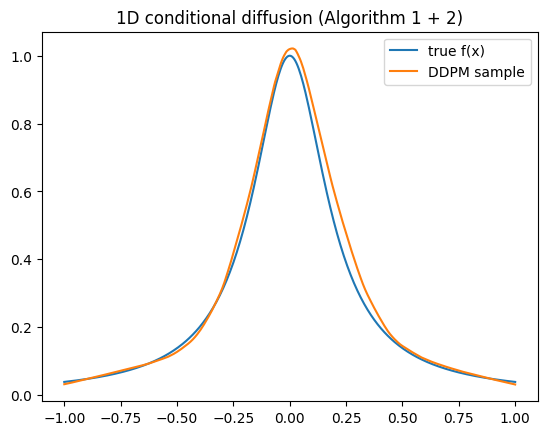

MSE: 0.0010068999836221337


In [10]:
train_loop()
xg, yhat = sample_on_grid(n_points=401)
ytrue     = f(xg)

plt.figure()
plt.plot(xg, ytrue, label='true f(x)')
plt.plot(xg, yhat,  label='DDPM sample')
plt.legend(); plt.title('1D conditional diffusion (Algorithm 1 + 2)')
plt.show()

mse = ((ytrue - yhat)**2).mean().item()
print("MSE:", mse)

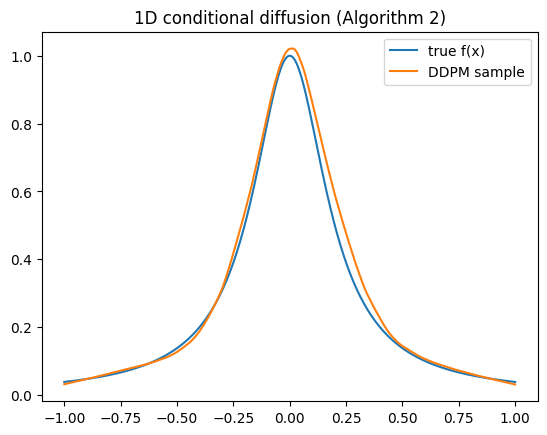

MSE: 0.0010064347879961133


In [11]:
# 取樣 + 畫圖 + MSE
xg, yhat = sample_on_grid(n_points=401)  # ← Alg.2 反向迭代
ytrue     = f(xg)

import matplotlib.pyplot as plt
plt.plot(xg, ytrue, label='true f(x)')
plt.plot(xg, yhat,  label='DDPM sample')
plt.legend(); plt.title('1D conditional diffusion (Algorithm 2)')
plt.show()

mse = ((ytrue - yhat)**2).mean().item()
print("MSE:", mse)


---

[train] step  100 | loss 0.005157
[train] step  200 | loss 0.005602
[train] step  300 | loss 0.004743
[train] step  400 | loss 0.003584
[train] step  500 | loss 0.012430
[train] step  600 | loss 0.008756
[train] step  700 | loss 0.017722
[train] step  800 | loss 0.011908
[train] step  900 | loss 0.013277
[train] step 1000 | loss 0.013095
[train] step 1100 | loss 0.002244
[train] step 1200 | loss 0.022604
[train] step 1300 | loss 0.002949
[train] step 1400 | loss 0.001556
[train] step 1500 | loss 0.004972
[train] step 1600 | loss 0.008373
[train] step 1700 | loss 0.001806
[train] step 1800 | loss 0.008973
[train] step 1900 | loss 0.003191
[train] step 2000 | loss 0.007705


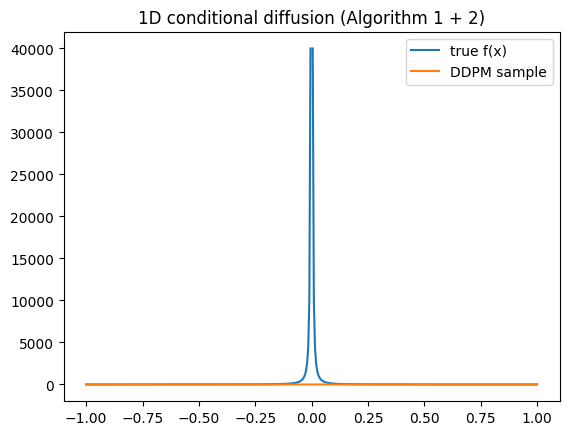

MSE: inf


In [14]:
def f2(x):
    return 1.0/x**2.0


train_loop()
xg, yhat = sample_on_grid(n_points=401)
ytrue     = f2(xg)

plt.figure()
plt.plot(xg, ytrue, label='true f(x)')
plt.plot(xg, yhat,  label='DDPM sample')
plt.legend(); plt.title('1D conditional diffusion (Algorithm 1 + 2)')
plt.show()

mse = ((ytrue - yhat)**2).mean().item()
print("MSE:", mse)

## Test for the test loss